In [1]:
torch.setdefaulttensortype('torch.FloatTensor')
require 'cutorch'

exact = true
separateParams = false
GPUs = {1}

### Load the dataset

In [2]:
dataset = require 'cifar10'

dataset.relative = '../../Datasets/CIFAR-10/cifar10_whitened_float.t7'
nClasses = dataset.nClasses -- 10

trainFiles = dataset.loadNames('train')
valFiles = dataset.loadNames('val')

In [3]:
require 'cunn'
require 'cudnn'

if #GPUs > 1 then
    local function bnparams(self)
       local p, gp = nn.Module.parameters(self)
        p[#p+1] = self.running_mean
        p[#p+1] = self.running_var
        gp[#gp+1] = self.running_mean:clone():zero()
        gp[#gp+1] = self.running_var:clone():zero()
        return p, gp
    end

    torch.getconstructortable('nn.BatchNormalization').parameters = bnparams
    torch.getconstructortable('cudnn.BatchNormalization').parameters = bnparams
end

cudnn.fastest = true
cudnn.benchmark = true

In [4]:
modelName = '000-wrn-40-2'

### Render images for displaying

3	


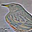

1	


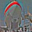

In [5]:
-- example blending
local k = 19
local img, label = dataset.loadSample(trainFiles[k])
print(label)
itorch.image(img)

local k = 190
local img, label = dataset.loadSample(trainFiles[k])
print(label)
itorch.image(img)

In [6]:
intKind = 'IntegralSmartNorm'
_G[intKind] = nil
debug.getregistry()[intKind] = nil 
package.loaded[intKind] = nil

require(intKind)

In [7]:
local modelName = modelName
net = assert(loadfile('ModelsClassification/' .. modelName .. '.lua'))(dataset.h, dataset.w, nClasses)

ints = net:findModules(intKind)
for i = 1,#ints do
    ints[i].normalize = true
    ints[i].exact = exact
    ints[i].saveMemoryIntegral = false
end
print('Number of IntegralSmartNorm modules: ' .. #ints)

net:cuda()
collectgarbage()

Number of IntegralSmartNorm modules: 0	


In [8]:
math.randomseed(666)
torch.manualSeed(666)
if CUDA then cutorch.manualSeed(666) end

if #GPUs > 1 then
    net = nn.DataParallelTable(1, true, true):threads(
        function()
            require 'cudnn'
            require 'IntegralSmartNorm'
        end)
        :cuda():add(net, GPUs)
end

net:reset()

if separateParams then
    params, gradParams = net:parameters()
else
    params, gradParams = net:getParameters()
end

In [9]:
require 'optim'

datasetIdx = 1

if separateParams then
    optimStates = {}

    local intParamsCount = 0

    for i = 1,#params do
        optimStates[i] = {
            learningRate = 1e-3,
            momentum = 0.9,
            nesterov = true,
            dampening = 0,
            learningRateDecay = 0,
            weightDecay = 2e-4
        }

        for k = 1,#ints do
            if 
                params[i] == ints[k].xMin or
                params[i] == ints[k].xMax or
                params[i] == ints[k].yMin or
                params[i] == ints[k].yMax then

                ints[k].params = ints[k].params or {}
                table.insert(ints[k].params, i)

                optimStates[i].weightDecay = 2e-4 -- 0.0185
                optimStates[i].learningRate = optimStates[i].learningRate
                intParamsCount = intParamsCount + 1
                break
            end
        end
    end

    print('Number of IntegralSmartNorm parameter tensors: ' .. intParamsCount)
else
    optimStates = {
        learningRate = 1e-3,
        momentum = 0.9,
        nesterov = true,
        dampening = 0,
        learningRateDecay = 0,
        weightDecay = 2e-4
    }
end

In [10]:
outputDir = 'CIFAR-10 classification/' .. modelName .. '/001/'

In [11]:
-- do return end

for k = 1,#ints do
    for p = 1,ints[k].xMin:nElement() do
        ints[k]:resetSingleWindow(p)
    end
    ints[k].xMin:mul(1.5)
    ints[k].xMax:mul(1.5)
    ints[k].yMin:mul(1.5)
    ints[k].yMax:mul(1.5)
end

In [12]:
-- Load a saved model
do return end
require 'nngraph'
require 'cunn'
require 'cudnn'

net, optimStates, GSconfig = table.unpack(torch.load(outputDir .. 'net.t7'))

net:cuda()

local poolings   = net:findModules('nn.SpatialMaxPooling')
local unpoolings = net:findModules('nn.SpatialMaxUnpooling')
for i = 1,#unpoolings do
    unpoolings[i].pooling = poolings[#poolings-i+1]
end

ints = net:findModules(intKind)
for i = 1,#ints do
    ints[i].normalize = true
    ints[i].exact = exact
end

require 'optim'

loaded = true

if #GPUs > 1 then
    net = nn.DataParallelTable(1, true, true):threads(
        function()
            require 'cudnn'
            require 'IntegralSmartNorm'
        end)
        :cuda():add(net, GPUs)
end

if separateParams then
    params, gradParams = net:parameters()
else
    params, gradParams = net:getParameters()
end

datasetIdx = 1

In [13]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

-- ints = {1,1,1,1,1,1,1,1}
wDebs = (#ints > 0) and {} or nil
for k = 1,#ints do wDebs[k] = WindowDebugger() end

In [14]:
require 'optim'

onlineLossLogger = optim.Logger(outputDir .. 'onlineLossLog.log')
evalLogger = optim.Logger(outputDir .. 'evalLog.log')
evalAccLogger = optim.Logger(outputDir .. 'evalAccLog.log')

onlineLossLogger:setNames{'Online batch loss'}
evalLogger:setNames{'Train loss', 'Validation loss'}
evalAccLogger:setNames{'Train error', 'Validation error'}

onlineLossLogger:style{'-'}
evalLogger:style{'-', '-'}
evalAccLogger:style{'-', '-'}

onlineLossLogger.showPlot = false
evalLogger.showPlot = false
evalAccLogger.showPlot = false

function needToPlot(_onlineLossLogger)
    local plotFreq = 100
    local count = #_onlineLossLogger.symbols[1] + 1
    while count > 1000 do
        plotFreq = plotFreq * 10
        count = count / 10
    end
    
    return #_onlineLossLogger.symbols[1] % plotFreq == 0
end

In [15]:
for k = 1,#ints do
    if wDebs and loaded and paths.filep(outputDir .. 'wd' .. k .. '.t7') then
        wDebs[k]:load(outputDir .. 'wd' .. k .. '.t7')
    end
end

if loaded and paths.filep(outputDir .. 'evalLogger.t7') then
    evalLogger.symbols = torch.load(outputDir .. 'evalLogger.t7')
end
if loaded and paths.filep(outputDir .. 'evalAccLogger.t7') then
    evalAccLogger.symbols = torch.load(outputDir .. 'evalAccLogger.t7')
end
if loaded and paths.filep(outputDir .. 'onlineLossLogger.t7') then
    onlineLossLogger.symbols = torch.load(outputDir .. 'onlineLossLogger.t7')
end

In [16]:
do return end

-- Measure forward/backward propagation time
-- input = torch.CudaTensor(1, 3, dataset.h, dataset.w):fill(0.1)
input = batch
local exactTest = false
net:evaluate()

for k = 1,#ints do
    ints[k].exact = exactTest
end

timer = torch.Timer()
for k = 1,nRepeats do
    net:forward(input)
--     net:backward(input, net.output:clone())
end
cutorch.synchronize()

for k = 1,#ints do
    ints[k].exact = exact
end

print('Average time for 1 forward pass: ' .. (timer:time().real) .. ' seconds. Output size:')
print(net.output:size())

collectgarbage()

In [17]:
criterion = nn.CrossEntropyCriterion():cuda()

In [18]:
evaluationIdxTrain = {}
for k = 1,#trainFiles,5 do table.insert(evaluationIdxTrain, k) end

evaluationIdxVal = {}
for k = 1,#valFiles do table.insert(evaluationIdxVal, k) end

In [19]:
function evaluate(net, files, indices)
    batchSize = batchSize or 16
    
    if not batch or batch:size(1) ~= batchSize then
        batch = torch.CudaTensor(batchSize, 3, dataset.h, dataset.w)
        batchLabels = torch.CudaByteTensor(batchSize)

        batchCPU = cutorch.createCudaHostFloatTensor(batch:size())
        batchLabelsCPU = cutorch.createCudaHostByteTensor(batchLabels:size())

        -- for async copy
        cutorch.reserveStreams(1)
        batchR, batchLabelsR = batch:clone(), batchLabels:clone()
    end
    
    local threadLog = {write=function()end, close=function()end, flush=function()end}
    -- local threadLog = io.open(outputDir .. 'threadLog.txt', 'w')
    
    local losses = {}
    local avgLoss = 0
    local confMatrix = torch.LongTensor(dataset.nClasses, dataset.nClasses):zero()
    
    -- Asynchronous image loading
    threads = require 'threads'
    threads.serialization('threads.sharedserialize')
    threads.Threads.serialization('threads.sharedserialize')
    require 'Queue'
    local queue = Queue() -- a queue of preprocessed input images
    local qMutex = threads.Mutex()
    queue.put = threads.safe(queue.put, qMutex)
    queue.get = threads.safe(queue.get, qMutex)
    local loadNThreads = 6
    
    -- initialize load worker
    local _data, _labels = dataset.data, dataset.labels
    local loadPool = threads.Threads(
        loadNThreads,
        function(threadId)
            (require 'sys').sleep((threadId-1) / 24)
            dataset = require 'cifar10'

            dataset.data = _data
            dataset.labels = _labels
            nClasses = dataset.nClasses -- 10
            
            torch.setnumthreads(1)

            threadFiles = files
        end,

        function(threadId)
--             print('Launching eval load thread #' .. threadId)
        end
    )
    
    local indicesIdx = 1 -- index of current test sample in `indices`
    local numImagesProcessed = 0
    
    -- add some jobs
    for _ = 1,math.min(batchSize, #indices) do
        loadPool:addjob(
            function(idx)
                local img, label = dataset.loadSample(threadFiles[idx])
                return idx, img, label
            end,

            function(idx, img, label)
                queue:put({idx, img, label})
            end,

            indices[indicesIdx]
        )
        indicesIdx = indicesIdx + 1
    end
    
    -- fill first batch
    batchIndicesR = {}
    for k = 1,math.min(batchSize, #indices) do
        if indicesIdx <= #indices then
            loadPool:addjob(
                function(idx)
                    local img, label = dataset.loadSample(threadFiles[idx])
                    return idx, img, label
                end,

                function(idx, img, label)
                    queue:put({idx, img, label})
                end,

                indices[indicesIdx]
            )
            indicesIdx = indicesIdx + 1
        end

        if queue:empty() then
            loadPool:dojob()
        end

        if queue:empty() then -- should never enter this
            threadLog:write('Q empty again\n'); threadLog:flush()
            os.execute('touch "' .. outputDir .. 'QEMPTY"')
            while queue:empty() do end
        end

        local idx, input, target = table.unpack(queue:get())
        threadLog:write('Consume\n'); threadLog:flush()

        table.insert(batchIndicesR, idx)
        batchCPU[k]:copy(input)
        batchLabelsCPU[k] = target
    end
    
    batchR:copy(batchCPU)
    batchLabelsR:copy(batchLabelsCPU)
    
    while numImagesProcessed < #indices do
        -- prepare for filling 'standby' batch
        cutorch.streamSynchronize(1)
        batch, batchR = batchR, batch
        batchLabels, batchLabelsR = batchLabelsR, batchLabels
        batchIndices, batchIndicesR = batchIndicesR, batchIndices
        
        -- fill the 'standby' batch, adding image loading tasks as needed
        batchIndicesR = {}
        for k = 1,batchSize do
            threadLog:write('Add,k=' .. k .. '\n'); threadLog:flush()
            
            if indicesIdx <= #indices then
                loadPool:addjob(
                    function(idx)
                        local img, label = dataset.loadSample(threadFiles[idx])
                        return idx, img, label
                    end,

                    function(idx, img, label)
                        queue:put({idx, img, label})
                    end,

                    indices[indicesIdx]
                )
                indicesIdx = indicesIdx + 1
            end

            if queue:empty() then
                if loadPool:hasjob() then
                    loadPool:dojob()
                else
                    -- no more files left
                    break
                end
            end
            
            if queue:empty() then -- should never enter this
                threadLog:write('Q empty again\n'); threadLog:flush()
                os.execute('touch "' .. outputDir .. 'QEMPTY"')
                while queue:empty() do end
            end

            local idx, input, target = table.unpack(queue:get())
            threadLog:write('Consume\n'); threadLog:flush()

            table.insert(batchIndicesR, idx)
            batchCPU[k]:copy(input)
            batchLabelsCPU[k] = target
            k = k + 1
        end

        -- start copying the 'standby' batch to GPU
        cutorch.setStream(1)
        
        batchR:copyAsync(batchCPU)
        batchLabelsR:copyAsync(batchLabelsCPU)
        
        -- forward the other batch through CNN
        cutorch.setStream(0)
        
        local outputs = net:forward(batch) -- batchSize x nClasses
        
        -- compute loss
        batchLoss = criterion:forward(
            outputs    [{{1, #batchIndices}}], 
            batchLabels[{{1, #batchIndices}}])
        -- dirty fix: normalize by the actual batch size
        batchLoss = batchLoss / #batchIndices * batchSize
        
        -- evaluate dataset metrics
        local predictedLabels = select(2, outputs:max(2)):squeeze():long()
        
        dataset.updateConfusionMatrix(
            confMatrix,
            predictedLabels[{{1, #batchIndices}}],
            batchLabels    [{{1, #batchIndices}}]:byte())
        
        numImagesProcessed = numImagesProcessed + #batchIndices
        avgLoss = avgLoss + batchLoss
    end
    
    local accuracy = dataset.accuracy(confMatrix)
    avgLoss = avgLoss / math.ceil(#indices / batchSize)
    
    collectgarbage()
    
    loadPool:terminate()
    qMutex:free()
    threadLog:close()
    
    return avgLoss, accuracy, confMatrix
end

## Training loop

In [20]:
function augment(img)
    img = torch.random() % 2 == 0 and img or image.hflip(img)

    -- from https://github.com/szagoruyko/wide-residual-networks/blob/master/train.lua#L103
    local img = imgPadder:forward(img):clone()
    
    local angle = (math.random() * 2 - 1) * 8.0 / 180 * math.pi
    img = image.rotate(img, angle, 'bilinear')
    
    local xShift = torch.random(4, imgPadder.pad_l*2 - 2)
    local yShift = torch.random(4, imgPadder.pad_t*2 - 2)
    
    return img
        :narrow(2, yShift, dataset.h)
        :narrow(3, xShift, dataset.w)
end

In [21]:
function copyConvert(obj, t)
   local copy = {}
   for k, v in pairs(obj) do
      if type(v) == 'table' then
         copy[k] = copyConvert(v, t)
      elseif torch.isTensor(v) then
         if k == 'output' or k == 'gradInput' then
            copy[k] = torch.Tensor():type(t)
         else
            copy[k] = v:type(t)
         end
      elseif k == '_type' then
         copy[k] = t
      else
         copy[k] = v
      end
   end
   if torch.typename(obj) then
      torch.setmetatable(copy, torch.typename(obj))
   end
   return copy
end

In [22]:
-- optimStates.learningRate = 1e-3

In [ ]:
-- threadLog = io.open(outputDir .. 'threadLog.txt', 'w')
threadLog = {write=function()end, close=function()end, flush=function()end}

batchSize = 128
shuffleEvery = math.ceil(#trainFiles / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = shuffleEvery -- how often to output loss to `losses` table and to redraw loss graph
saveFreq = shuffleEvery*2 -- how often to save `net` and `windowDebugger`s

-- Asynchronous image loading
threads = require 'threads'
threads.serialization('threads.sharedserialize')
threads.Threads.serialization('threads.sharedserialize')
require 'Queue'
local queue = Queue() -- a queue of preprocessed input images
local qMutex = threads.Mutex()
queue.put = threads.safe(queue.put, qMutex)
queue.get = threads.safe(queue.get, qMutex)

local nThreads = 2
local timer = torch.Timer()
local _data, _labels, _trainFiles, _augment = dataset.data, dataset.labels, trainFiles, augment

local pool = threads.Threads(
    nThreads,
    function(threadId)
        (require 'sys').sleep((threadId-1) / 7)
        require 'nn'
        require 'image'
        require 'Queue'
        threadTrainFiles = _trainFiles
        dataset = require 'cifar10'
        
        torch.setnumthreads(1)

        dataset.data = _data
        dataset.labels = _labels
        nClasses = dataset.nClasses -- 19
        augment = _augment
        
        imgPadder = nn.SpatialReflectionPadding(
            dataset.w * 0.2, dataset.w * 0.2,
            dataset.h * 0.2, dataset.h * 0.2):float()
    end,

    function(threadId)
        print('Launching thread #' .. threadId)
    end
)

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,#trainFiles do
    idx[i] = i
end

local avgLoss = 0

net:training()

collectgarbage()

if not batch or batch:size(1) ~= batchSize then
    batch = torch.CudaTensor(batchSize, 3, dataset.h, dataset.w)
    batchLabels = torch.CudaByteTensor(batchSize)
    
    batchCPU  = cutorch.createCudaHostFloatTensor(batch:size())
    batchCPUR = cutorch.createCudaHostFloatTensor(batch:size()) -- need this for image saving
    batchLabelsCPU  = cutorch.createCudaHostByteTensor(batchLabels:size())
    batchLabelsCPUR = cutorch.createCudaHostByteTensor(batchLabels:size())
    
    -- for async copy
    cutorch.reserveStreams(1)
    batchR, batchLabelsR = batch:clone(), batchLabels:clone()
end

for _ = 1,24 do
    pool:addjob(
        function(nextFileIdx)
            local img, label = dataset.loadSample(threadTrainFiles[nextFileIdx])
            img = augment(img)
            return img, label
        end,

        function(img, label)
            queue:put({img, label})
        end,

        idx[datasetIdx]
    )
    datasetIdx = datasetIdx % #trainFiles + 1
end

for k = 1,batchSize do      
    pool:dojob()
    pool:addjob(
        function(nextFileIdx)
            local img, label = dataset.loadSample(threadTrainFiles[nextFileIdx])
            img = augment(img)
            if label == 1 and torch.random() % 2 == 0 then collectgarbage() end
            return img, label
        end,

        function(img, label)
            queue:put({img, label})
        end,

        idx[datasetIdx]
    )
    datasetIdx = datasetIdx % #trainFiles + 1

    if queue:empty() then -- should never enter this
        threadLog:write('Q empty again\n'); threadLog:flush()
        os.execute('touch "' .. outputDir .. 'QEMPTY"')
        while queue:empty() do end
    end

    local input, target = table.unpack(queue:get())
    threadLog:write('Consume\n'); threadLog:flush()

    batchCPU[k]:copy(input)
    batchLabelsCPU[k] = target
end

batchR:copy(batchCPU)
batchLabelsR:copy(batchLabelsCPU)

-- ************** Main loop ***************

for iter = 1,1e9 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    if math.max(iter,1) % (40e2*outputFreq) == 0 then
        local optimStatesList = separateParams and optimStates or {optimStates}
        for k = 1,#optimStatesList do
            optimStatesList[k].learningRate = optimStatesList[k].learningRate / 10
--             optimStatesList[k].t = 0
--             optimStatesList[k].m:zero()
--             optimStatesList[k].v:zero()
        end
    end
    
    if wDebs and (iter-1) % 200 == 0 then
        for k = 1,#wDebs do
            wDebs[k]:add(ints[k])
        end
    end
    
    if (iter-1) % saveFreq == 0 then
        torch.save(outputDir .. 'net.t7', 
            {copyConvert(#GPUs > 1 and net:get(1) or net, 'torch.FloatTensor'):clearState(), 
            optimStates, GSconfig})
        
        torch.save(outputDir .. 'evalLogger.t7', evalLogger.symbols)
        torch.save(outputDir .. 'evalAccLogger.t7', evalAccLogger.symbols)
        torch.save(outputDir .. 'onlineLossLogger.t7', onlineLossLogger.symbols)
        
        if wDebs then
            for k = 1,#wDebs do
                wDebs[k]:save(outputDir .. 'wd' .. k .. '.t7')
            end
        end
    end
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        threadLog:write('other time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
        
        -- start filling 'standby' batch
        cutorch.streamSynchronize(1)
        batch, batchR = batchR, batch
        batchLabels, batchLabelsR = batchLabelsR, batchLabels
        
        threadLog:write('sync time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
        
        for k = 1,batchSize do      
            pool:addjob(
                function(nextFileIdx)
                    local img, label = dataset.loadSample(threadTrainFiles[nextFileIdx])
                    img = augment(img)
                    if label == 1 and torch.random() % 2 == 0 then collectgarbage() end
                    return img, label
                end,

                function(img, label)
                    queue:put({img, label})
                end,

                idx[datasetIdx]
            )
            datasetIdx = datasetIdx % #trainFiles + 1
            
            if queue:empty() then
                threadLog:write('Q empty\n'); threadLog:flush()
                pool:dojob()
            end

            if queue:empty() then -- should never enter this
                threadLog:write('Q empty again\n'); threadLog:flush()
                os.execute('touch "' .. outputDir .. 'QEMPTY"')
                while queue:empty() do end
            end

            local input, target = table.unpack(queue:get())
            threadLog:write('Consume\n'); threadLog:flush()

            batchCPU[k]:copy(input)
            batchLabelsCPU[k] = target
        end
        threadLog:write('stby batch fill time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
        
        cutorch.setStream(1)
        
        batchR:copyAsync(batchCPU)
        batchLabelsR:copyAsync(batchLabelsCPU)
        
        cutorch.setStream(0)
        
--         print('start fwd')
        threadLog:write('batch transfer time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
        net:forward(batch) -- batchSize x nClasses
        batchLoss = criterion:forward(net.output, batchLabels)
--         print('end fwd')
        net:zeroGradParameters()
--         print('start bwd')
        criterion:backward(net.output, batchLabels)
        if iter % 20 == 0 then collectgarbage() end
        net:backward(batch, criterion.gradInput) -- accumulate gradients
--         print('end bwd')
        
        threadLog:write('fwd+bwd exec time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
    end -- do
    
    -- detect NaNs
    function hasNaN(x) return x:ne(x):sum() > 0 end
    if batchLoss ~= batchLoss then -- or hasNaN(net.output) then
        print('Loss is NaN')
        break
    end
    
    if iter % 10 == 0 then onlineLossLogger:add{batchLoss} end
    if needToPlot(onlineLossLogger) then onlineLossLogger:plot() end
--     print('start optim')
    -- optimization step
    if separateParams then
        for i = 1,#params do
            local feval = function(x)
                return batchLoss, gradParams[i]
            end
            optim.adam(feval, params[i], optimStates[i])
        end
    else
        local feval = function(x)
            return batchLoss, gradParams
        end
        optim.adam(feval, params, optimStates)
    end
    threadLog:write('opt time: ' .. timer:time().real .. '\n'); threadLog:flush(); timer:reset()
    
    if iter % 20 == 0 then collectgarbage() end
    
    if iter % outputFreq == 0 then
        net:evaluate()
        
        local trainLoss, trainAcc = evaluate(net, trainFiles, evaluationIdxTrain)
        local valLoss, valAcc = evaluate(net, valFiles, evaluationIdxVal)
        
        collectgarbage()
        
        evalLogger:add{trainLoss, valLoss}
        evalLogger:plot()
        evalAccLogger:add{100*(1-trainAcc), 100*(1-valAcc)}
        evalAccLogger:plot()
        
        net:training()
    end
    
    if lfs.attributes(outputDir .. 'INTERRUPT') then
        os.rename(outputDir .. 'INTERRUPT', outputDir .. 'INTERRUPT_')
        break
    end
end

pool:terminate()
qMutex:free()
threadLog:close()

if wDebs then
    for k = 1,#wDebs do
        wDebs[k]:save(outputDir .. 'wd' .. k .. '.t7')
    end
end

collectgarbage()

Launching thread #1


Launching thread #2


Epoch 0	


Epoch 1	


Epoch 2	


In [5]:
local optimStatesList = separateParams and optimStates or {optimStates}
for k = 1,#optimStatesList do
    optimStatesList[k].learningRate = optimStatesList[k].learningRate / 2
--     optimStatesList[k].t = 0
--     optimStatesList[k].m:zero()
--     optimStatesList[k].v:zero()
end

In [25]:
1e-3 / optimStates.learningRate

1	


In [2]:
-- do this after INTERRUPTing
torch.save(outputDir .. 'net.t7', {copyConvert(#GPUs > 1 and net:get(1) or net, 'torch.FloatTensor'):clearState(), optimStates, GSconfig})

torch.save(outputDir .. 'evalLogger.t7', evalLogger.symbols)
torch.save(outputDir .. 'evalAccLogger.t7', evalAccLogger.symbols)
torch.save(outputDir .. 'onlineLossLogger.t7', onlineLossLogger.symbols)

if wDebs then
    for k = 1,#wDebs do
        wDebs[k]:exportVideo(outputDir .. 'int-layer-' .. k .. '.avi')
    end
end

## Export images for evaluation by `cityscapesScripts`

In [26]:
local timer = torch.Timer()
net:evaluate()
print(net.train)

valLoss, valAcc, confMatrix = evaluate(net, valFiles, evaluationIdxVal)

net:training()
print(timer:time().real .. ' seconds')

false	


nil	nil	


46.555427074432 seconds	


In [33]:
math.exp(-valLoss)

0.98914853565462	
